# 📅 Day 2: Data Preprocessing & Feature Engineering
## CIC-IoT-2023 — GPU-Accelerated Pipeline

---

**Steps:**
1. Load combined parquet data
2. Clean: handle inf/NaN, remove constant & highly correlated features
3. Label Engineering: create binary, 8-class family, 34-class subtype labels
4. Feature Scaling (StandardScaler)
5. Stratified 80/20 Split
6. Save preprocessed data

---

In [1]:
import os
os.add_dll_directory(r'C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v13.1\bin\x64')

import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc
import joblib
import json
from datetime import datetime

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

os.makedirs('processed', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('figures', exist_ok=True)

print(f"✅ Ready | {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Ready | 2026-02-26 07:07:03


## 📥 Step 1: Load Data

In [2]:
PARQUET_PATH = 'processed/all_data_full.parquet'

print("⏳ Loading full dataset...")
t0 = time.time()

# Read metadata first
pf = pq.ParquetFile(PARQUET_PATH)
total_rows = pf.metadata.num_rows
print(f"   Total rows: {total_rows:,}")
print(f"   File size:  {os.path.getsize(PARQUET_PATH)/1e9:.2f} GB")

# Load the full table
table = pq.read_table(PARQUET_PATH)
df = table.to_pandas()
del table
gc.collect()

print(f"✅ Loaded in {time.time()-t0:.1f}s")
print(f"   Shape: {df.shape}")
print(f"   Memory: {df.memory_usage(deep=True).sum()/1e9:.2f} GB")
df.head()

⏳ Loading full dataset...
   Total rows: 46,686,579
   File size:  3.14 GB


✅ Loaded in 36.3s
   Shape: (46686579, 47)


   Memory: 18.27 GB


,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,54.00,6.00,64.00,0.329807,0.329807,0.0,1.0,0.0,1.0,...,0.000000,54.00,8.334383e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood
1,0.000000,57.04,6.33,64.00,4.290556,4.290556,0.0,0.0,0.0,0.0,...,2.822973,57.04,8.292607e+07,9.5,10.464666,4.010353,160.987842,0.05,141.55,DoS-TCP_Flood
2,0.000000,0.00,1.00,64.00,33.396799,33.396799,0.0,0.0,0.0,0.0,...,0.000000,42.00,8.312799e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood
3,0.328175,76175.00,17.00,64.00,4642.133010,4642.133010,0.0,0.0,0.0,0.0,...,0.000000,50.00,8.301570e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood
4,0.117320,101.73,6.11,65.91,6.202211,6.202211,0.0,0.0,1.0,0.0,...,23.113111,57.88,8.297300e+07,9.5,11.346876,32.716243,3016.808286,0.19,141.55,DoS-SYN_Flood


## 🧹 Step 2: Data Cleaning

In [3]:
# Separate label from features
label_col = 'label'
labels_original = df[label_col].copy()
feature_cols_all = [c for c in df.columns if c != label_col]
print(f"📊 Original features: {len(feature_cols_all)}")
print(f"📊 Unique labels: {labels_original.nunique()}")
print(f"\n📋 Label distribution:")
print(labels_original.value_counts())

📊 Original features: 46


📊 Unique labels: 34

📋 Label distribution:


label
DDoS-ICMP_Flood            7200504
DDoS-UDP_Flood             5412287
DDoS-TCP_Flood             4497667
DDoS-PSHACK_Flood          4094755
DDoS-SYN_Flood             4059190
DDoS-RSTFINFlood           4045285
DDoS-SynonymousIP_Flood    3598138
DoS-UDP_Flood              3318595
DoS-TCP_Flood              2671445
DoS-SYN_Flood              2028834
BenignTraffic              1098195
Mirai-greeth_flood          991866
Mirai-udpplain              890576
Mirai-greip_flood           751682
DDoS-ICMP_Fragmentation     452489
MITM-ArpSpoofing            307593
DDoS-UDP_Fragmentation      286925
DDoS-ACK_Fragmentation      285104
DNS_Spoofing                178911
Recon-HostDiscovery         134378
Recon-OSScan                 98259
Recon-PortScan               82284
DoS-HTTP_Flood               71864
VulnerabilityScan            37382
DDoS-HTTP_Flood              28790
DDoS-SlowLoris               23426
DictionaryBruteForce         13064
BrowserHijacking              5859
CommandInjecti

In [4]:
# 2.1 Replace inf with NaN, then handle NaN
print("🧹 Cleaning inf/NaN values...")
X = df[feature_cols_all].copy()
del df
gc.collect()

# Count inf
inf_count = np.isinf(X.select_dtypes(include=[np.number])).sum().sum()
nan_count = X.isnull().sum().sum()
print(f"   Inf values:  {inf_count:,}")
print(f"   NaN values:  {nan_count:,}")

# Replace inf with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN with 0 (safe for tree-based models)
X.fillna(0, inplace=True)

print(f"   ✅ After cleaning: NaN={X.isnull().sum().sum()}, Inf={np.isinf(X.select_dtypes(include=[np.number])).sum().sum()}")

🧹 Cleaning inf/NaN values...


   Inf values:  0
   NaN values:  0


   ✅ After cleaning: NaN=0, Inf=0


In [5]:
# 2.2 Remove constant-variance features
print("\n🧹 Removing constant-variance features...")
constant_cols = [col for col in X.columns if X[col].nunique() <= 1]
if constant_cols:
    print(f"   ❌ Dropping {len(constant_cols)} constant columns: {constant_cols}")
    X.drop(columns=constant_cols, inplace=True)
else:
    print(f"   ✅ No constant columns found")
print(f"   Features remaining: {X.shape[1]}")


🧹 Removing constant-variance features...


   ✅ No constant columns found
   Features remaining: 46


In [6]:
# 2.3 Remove highly correlated features (>0.95)
print("\n🧹 Checking for highly correlated features (>0.95)...")
t0 = time.time()

# Use a sample for correlation computation to save memory
sample_size = min(500_000, len(X))
X_sample = X.sample(n=sample_size, random_state=42)
corr_matrix = X_sample.corr().abs()
del X_sample

# Get upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_cols = [col for col in upper.columns if any(upper[col] > 0.95)]

if high_corr_cols:
    print(f"   ❌ Dropping {len(high_corr_cols)} highly correlated columns: {high_corr_cols}")
    X.drop(columns=high_corr_cols, inplace=True)
else:
    print(f"   ✅ No highly correlated features found")

print(f"   Features remaining: {X.shape[1]}")
print(f"   Computed in {time.time()-t0:.1f}s")

feature_cols_final = list(X.columns)
print(f"\n📊 Final feature set ({len(feature_cols_final)} features):")
for i, c in enumerate(feature_cols_final):
    print(f"   {i+1:2d}. {c}")


🧹 Checking for highly correlated features (>0.95)...


   ❌ Dropping 10 highly correlated columns: ['Srate', 'rst_flag_number', 'cwr_flag_number', 'ack_count', 'LLC', 'Std', 'Number', 'Magnitue', 'Radius', 'Weight']


   Features remaining: 36
   Computed in 12.4s

📊 Final feature set (36 features):
    1. flow_duration
    2. Header_Length
    3. Protocol Type
    4. Duration
    5. Rate
    6. Drate
    7. fin_flag_number
    8. syn_flag_number
    9. psh_flag_number
   10. ack_flag_number
   11. ece_flag_number
   12. syn_count
   13. fin_count
   14. urg_count
   15. rst_count
   16. HTTP
   17. HTTPS
   18. DNS
   19. Telnet
   20. SMTP
   21. SSH
   22. IRC
   23. TCP
   24. UDP
   25. DHCP
   26. ARP
   27. ICMP
   28. IPv
   29. Tot sum
   30. Min
   31. Max
   32. AVG
   33. Tot size
   34. IAT
   35. Covariance
   36. Variance


## 🏷️ Step 3: Label Engineering (3 Levels)

In [7]:
# CICIoT2023 Official Taxonomy Mapping
FAMILY_MAP = {
    'BenignTraffic': 'BenignTraffic',
    # DDoS Family
    'DDoS-ACK_Fragmentation': 'DDoS',
    'DDoS-HTTP_Flood': 'DDoS',
    'DDoS-ICMP_Flood': 'DDoS',
    'DDoS-ICMP_Fragmentation': 'DDoS',
    'DDoS-PSHACK_Flood': 'DDoS',
    'DDoS-RSTFINFlood': 'DDoS',
    'DDoS-SlowLoris': 'DDoS',
    'DDoS-SYN_Flood': 'DDoS',
    'DDoS-SynonymousIP_Flood': 'DDoS',
    'DDoS-TCP_Flood': 'DDoS',
    'DDoS-UDP_Flood': 'DDoS',
    'DDoS-UDP_Fragmentation': 'DDoS',
    # DoS Family
    'DoS-HTTP_Flood': 'DoS',
    'DoS-SYN_Flood': 'DoS',
    'DoS-TCP_Flood': 'DoS',
    'DoS-UDP_Flood': 'DoS',
    # Mirai Family
    'Mirai-greeth_flood': 'Mirai',
    'Mirai-greip_flood': 'Mirai',
    'Mirai-udpplain': 'Mirai',
    # Recon Family
    'Recon-HostDiscovery': 'Recon',
    'Recon-OSScan': 'Recon',
    'Recon-PingSweep': 'Recon',
    'Recon-PortScan': 'Recon',
    # Spoofing Family
    'DNS_Spoofing': 'Spoofing',
    'MITM-ArpSpoofing': 'Spoofing',
    # Web Family
    'BrowserHijacking': 'Web',
    'CommandInjection': 'Web',
    'SqlInjection': 'Web',
    'Uploading_Attack': 'Web',
    'XSS': 'Web',
    # BruteForce Family
    'DictionaryBruteForce': 'BruteForce'
}

print("🏷️ Creating 3-level labels...")

# Level 1: Binary (Benign=0, Attack=1)
label_binary = (labels_original != 'BenignTraffic').astype(np.int8)

# Level 2: 8-Class Family
label_family_str = labels_original.map(FAMILY_MAP)
unmapped = label_family_str.isnull().sum()
if unmapped > 0:
    print(f"   ⚠️ {unmapped} unmapped labels found!")
    print(f"   Unknown labels: {labels_original[label_family_str.isnull()].unique()}")
    label_family_str.fillna('Unknown', inplace=True)

le_family = LabelEncoder()
label_family = le_family.fit_transform(label_family_str)

# Level 3: 34-Class SubType
le_subtype = LabelEncoder()
label_subtype = le_subtype.fit_transform(labels_original)

print(f"\n✅ Labels created:")
print(f"   Level 1 (Binary):   {np.unique(label_binary)} → Benign=0, Attack=1")
print(f"   Level 2 (Family):   {len(le_family.classes_)} classes → {list(le_family.classes_)}")
print(f"   Level 3 (SubType):  {len(le_subtype.classes_)} classes")

# Save encoders
joblib.dump(le_family, 'models/label_encoder_family.joblib')
joblib.dump(le_subtype, 'models/label_encoder_subtype.joblib')
print(f"\n💾 Label encoders saved to models/")

🏷️ Creating 3-level labels...


   ⚠️ 40600 unmapped labels found!


   Unknown labels: <ArrowStringArray>
['VulnerabilityScan', 'Backdoor_Malware']
Length: 2, dtype: str



✅ Labels created:
   Level 1 (Binary):   [0 1] → Benign=0, Attack=1
   Level 2 (Family):   9 classes → ['BenignTraffic', 'BruteForce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Unknown', 'Web']
   Level 3 (SubType):  34 classes

💾 Label encoders saved to models/


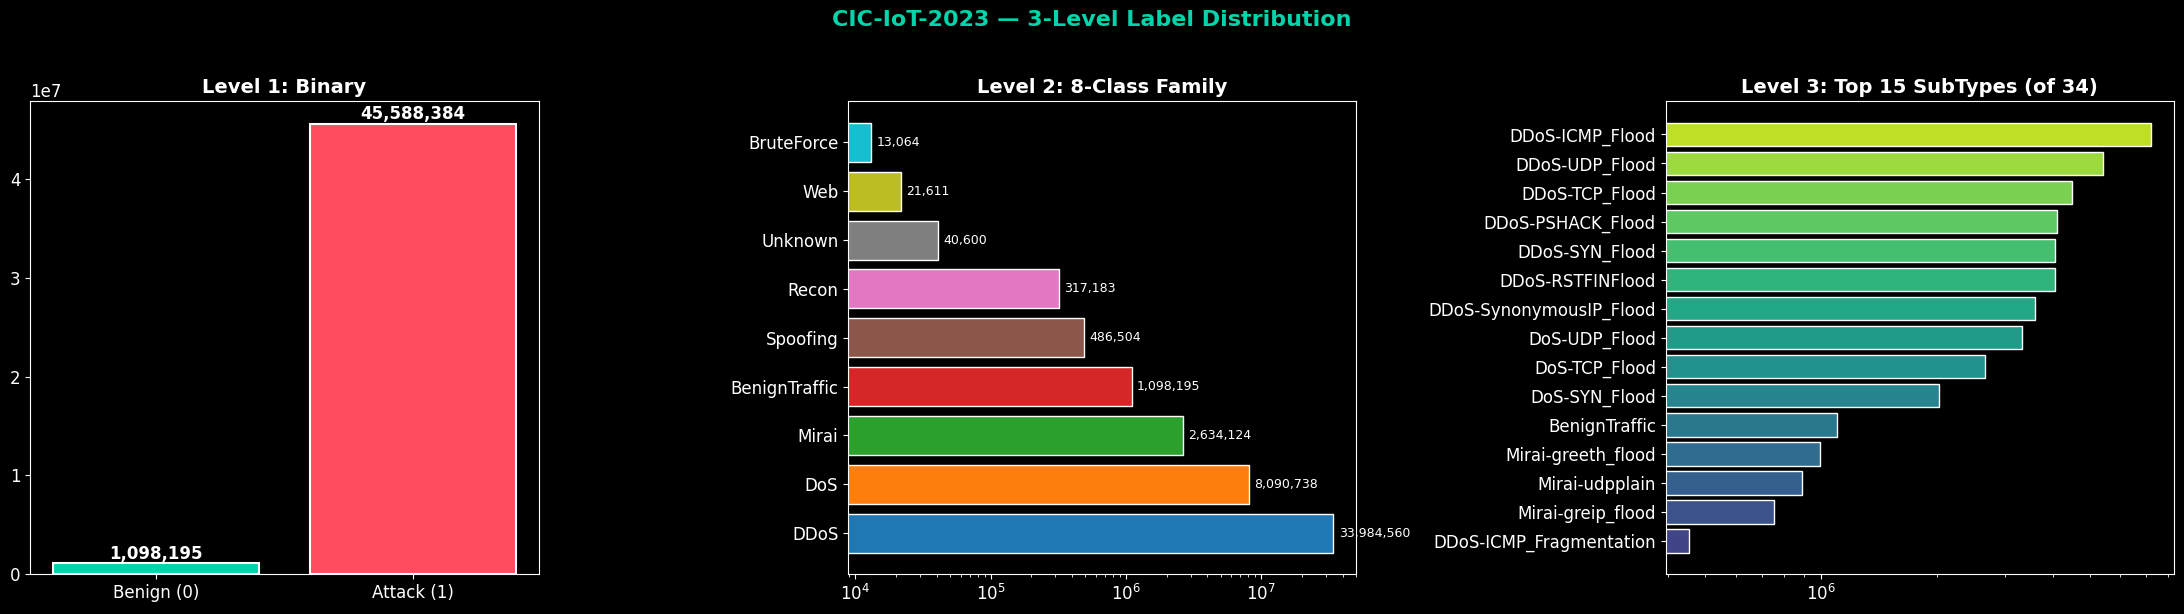

💾 Saved to figures/label_distributions.png


In [8]:
# 📊 Visualize label distributions
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# Binary
binary_counts = pd.Series(label_binary).value_counts().sort_index()
axes[0].bar(['Benign (0)', 'Attack (1)'], binary_counts.values, color=['#00D4AA', '#FF4C61'],
            edgecolor='white', linewidth=1.5)
axes[0].set_title('Level 1: Binary', fontsize=14, fontweight='bold', color='white')
for i, v in enumerate(binary_counts.values):
    axes[0].text(i, v + total_rows*0.01, f'{v:,}', ha='center', fontweight='bold', color='white')

# Family (8-class)
family_counts = pd.Series(label_family_str).value_counts()
colors_8 = plt.cm.tab10(np.linspace(0, 1, len(family_counts)))
axes[1].barh(family_counts.index, family_counts.values, color=colors_8, edgecolor='white')
axes[1].set_title('Level 2: 8-Class Family', fontsize=14, fontweight='bold', color='white')
axes[1].set_xscale('log')
for i, (name, v) in enumerate(family_counts.items()):
    axes[1].text(v * 1.1, i, f'{v:,}', va='center', fontsize=9, color='white')

# SubType (34-class) — top 15
subtype_counts = labels_original.value_counts()
top15 = subtype_counts.head(15)
colors_34 = plt.cm.viridis(np.linspace(0.2, 0.9, len(top15)))
axes[2].barh(top15.index[::-1], top15.values[::-1], color=colors_34, edgecolor='white')
axes[2].set_title('Level 3: Top 15 SubTypes (of 34)', fontsize=14, fontweight='bold', color='white')
axes[2].set_xscale('log')

plt.suptitle('CIC-IoT-2023 — 3-Level Label Distribution', fontsize=16, fontweight='bold', color='#00D4AA', y=1.02)
plt.tight_layout()
plt.savefig('figures/label_distributions.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()
print("💾 Saved to figures/label_distributions.png")

## 📐 Step 4: Feature Scaling

In [9]:
print("📐 Applying StandardScaler...")
t0 = time.time()

# Convert to float32 to save memory
X_float = X.values.astype(np.float32)
del X
gc.collect()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_float).astype(np.float32)
del X_float
gc.collect()

# Save the scaler
joblib.dump(scaler, 'models/standard_scaler.joblib')

print(f"✅ Scaling done in {time.time()-t0:.1f}s")
print(f"   Shape: {X_scaled.shape}")
print(f"   Memory: {X_scaled.nbytes/1e9:.2f} GB")
print(f"💾 Scaler saved to models/standard_scaler.joblib")

📐 Applying StandardScaler...


✅ Scaling done in 20.6s
   Shape: (46686579, 36)
   Memory: 6.72 GB
💾 Scaler saved to models/standard_scaler.joblib


## ✂️ Step 5: Stratified Train/Test Split

In [10]:
# Use the most granular label (subtype) for stratification
# This ensures all 34 classes appear proportionally in both train and test
print("✂️ Stratified 80/20 split (stratified by 34-class subtype)...")
t0 = time.time()

X_train, X_test, y_binary_train, y_binary_test, y_family_train, y_family_test, y_subtype_train, y_subtype_test = train_test_split(
    X_scaled,
    label_binary,
    label_family,
    label_subtype,
    test_size=0.2,
    random_state=42,
    stratify=label_subtype
)

del X_scaled, label_binary, label_family, label_subtype
gc.collect()

print(f"✅ Split done in {time.time()-t0:.1f}s")
print(f"   Train: {X_train.shape[0]:,} samples")
print(f"   Test:  {X_test.shape[0]:,} samples")
print(f"   Features: {X_train.shape[1]}")

✂️ Stratified 80/20 split (stratified by 34-class subtype)...


✅ Split done in 41.0s
   Train: 37,349,263 samples
   Test:  9,337,316 samples
   Features: 36


In [11]:
# Verify stratification
print("📊 Verifying stratification (subtype proportions):")
train_dist = pd.Series(y_subtype_train).value_counts(normalize=True).sort_index()
test_dist = pd.Series(y_subtype_test).value_counts(normalize=True).sort_index()

verify_df = pd.DataFrame({
    'Train %': (train_dist * 100).round(3),
    'Test %': (test_dist * 100).round(3),
    'Class Name': [le_subtype.classes_[i] for i in train_dist.index]
})
print(verify_df.to_string())
print(f"\n✅ Max difference between train/test proportions: {abs(train_dist - test_dist).max()*100:.4f}%")

📊 Verifying stratification (subtype proportions):


    Train %  Test %               Class Name
0     0.007   0.007         Backdoor_Malware
1     2.352   2.352            BenignTraffic
2     0.013   0.013         BrowserHijacking
3     0.012   0.012         CommandInjection
4     0.611   0.611   DDoS-ACK_Fragmentation
5     0.062   0.062          DDoS-HTTP_Flood
6    15.423  15.423          DDoS-ICMP_Flood
7     0.969   0.969  DDoS-ICMP_Fragmentation
8     8.771   8.771        DDoS-PSHACK_Flood
9     8.665   8.665         DDoS-RSTFINFlood
10    8.695   8.695           DDoS-SYN_Flood
11    0.050   0.050           DDoS-SlowLoris
12    7.707   7.707  DDoS-SynonymousIP_Flood
13    9.634   9.634           DDoS-TCP_Flood
14   11.593  11.593           DDoS-UDP_Flood
15    0.615   0.615   DDoS-UDP_Fragmentation
16    0.383   0.383             DNS_Spoofing
17    0.028   0.028     DictionaryBruteForce
18    0.154   0.154           DoS-HTTP_Flood
19    4.346   4.346            DoS-SYN_Flood
20    5.722   5.722            DoS-TCP_Flood
21    7.10

## 💾 Step 6: Save Preprocessed Data

In [12]:
print("💾 Saving preprocessed data...")
t0 = time.time()

# Save as numpy arrays (fast loading)
np.save('processed/X_train.npy', X_train)
np.save('processed/X_test.npy', X_test)
np.save('processed/y_binary_train.npy', y_binary_train)
np.save('processed/y_binary_test.npy', y_binary_test)
np.save('processed/y_family_train.npy', y_family_train)
np.save('processed/y_family_test.npy', y_family_test)
np.save('processed/y_subtype_train.npy', y_subtype_train)
np.save('processed/y_subtype_test.npy', y_subtype_test)

# Save feature names and metadata
preprocess_meta = {
    'timestamp': datetime.now().isoformat(),
    'feature_names': feature_cols_final,
    'n_features': len(feature_cols_final),
    'train_size': int(X_train.shape[0]),
    'test_size': int(X_test.shape[0]),
    'total_rows': int(total_rows),
    'removed_constant_cols': constant_cols,
    'removed_correlated_cols': high_corr_cols,
    'family_classes': list(le_family.classes_),
    'subtype_classes': list(le_subtype.classes_),
    'family_map': FAMILY_MAP
}
with open('processed/preprocessing_metadata.json', 'w') as f:
    json.dump(preprocess_meta, f, indent=2)

t_save = time.time() - t0
print(f"✅ All data saved in {t_save:.1f}s")
print(f"\n📁 Saved files:")
saved_files = [
    'processed/X_train.npy', 'processed/X_test.npy',
    'processed/y_binary_train.npy', 'processed/y_binary_test.npy',
    'processed/y_family_train.npy', 'processed/y_family_test.npy',
    'processed/y_subtype_train.npy', 'processed/y_subtype_test.npy',
    'processed/preprocessing_metadata.json'
]
for f in saved_files:
    if os.path.exists(f):
        size_mb = os.path.getsize(f) / 1e6
        print(f"   ✅ {f} ({size_mb:.1f} MB)")

💾 Saving preprocessed data...


✅ All data saved in 37.9s

📁 Saved files:
   ✅ processed/X_train.npy (5378.3 MB)
   ✅ processed/X_test.npy (1344.6 MB)
   ✅ processed/y_binary_train.npy (37.3 MB)
   ✅ processed/y_binary_test.npy (9.3 MB)
   ✅ processed/y_family_train.npy (298.8 MB)
   ✅ processed/y_family_test.npy (74.7 MB)
   ✅ processed/y_subtype_train.npy (298.8 MB)
   ✅ processed/y_subtype_test.npy (74.7 MB)
   ✅ processed/preprocessing_metadata.json (0.0 MB)


In [13]:
print("\n" + "🎉" * 20)
print(f"\n  ✅ PREPROCESSING COMPLETE!")
print(f"  📊 {len(feature_cols_final)} features × {X_train.shape[0]+X_test.shape[0]:,} samples")
print(f"  🔹 Level 1 (Binary): 2 classes")
print(f"  🔹 Level 2 (Family): {len(le_family.classes_)} classes")
print(f"  🔹 Level 3 (SubType): {len(le_subtype.classes_)} classes")
print(f"  💾 Data saved to processed/")
print(f"\n" + "🎉" * 20)


🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

  ✅ PREPROCESSING COMPLETE!
  📊 36 features × 46,686,579 samples
  🔹 Level 1 (Binary): 2 classes
  🔹 Level 2 (Family): 9 classes
  🔹 Level 3 (SubType): 34 classes
  💾 Data saved to processed/

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
